In [1]:
import os

os.chdir("../")

In [2]:
import pandas as pd

from src.io.path_definition import get_file
from train.src.run_LSTM2LSTM import data_preparation

cancel_target = pd.read_csv(get_file(os.path.join('data', 'cancel_dataset_target.csv')), index_col=0)
date_feature = pd.read_csv(get_file(os.path.join('data', 'cancel_dataset_date_feature.csv')), index_col=0)

numerical_features, date_feature = data_preparation(hotel_id=57, date_feature=date_feature, cancel_target=cancel_target)

In [3]:
date_index = date_feature.index
date_index = [index.replace("/", "-") for index in date_index]
date_feature.index = date_index

In [4]:
bank_holiday_condition = (~date_feature['week'].isin(['SAT', 'SUN'])) & (date_feature['is_rest_day']==1)

bank_holiday = pd.DataFrame({
    'holiday': 'holiday',
    'ds': pd.to_datetime(date_feature[bank_holiday_condition].index.tolist()),
    'lower_window': -1,
    'upper_window': 1
})

weekend_condition = date_feature['week'].isin(['SAT', 'SUN'])

weekend = pd.DataFrame({
    'holiday': 'weekend',
    'ds': pd.to_datetime(date_feature[weekend_condition].index.tolist()),
    'lower_window': -1,
    'upper_window': 1
})

holidays = pd.concat((bank_holiday, weekend))

In [25]:
from prophet import Prophet

cancel_df = date_feature[['canceled']]
cancel_df.rename(columns={'canceled': 'y'}, inplace=True)

cancel_df.index.name = 'ds'
cancel_df.reset_index(inplace=True)

m = Prophet(holidays=holidays, weekly_seasonality=False, seasonality_mode='multiplicative')

C:\Users\MengChieh\Miniconda3\envs\hotelCancellation\lib\site-packages\pandas\core\frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
m.fit(cancel_df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
fit_value = m.predict(cancel_df[['ds']])

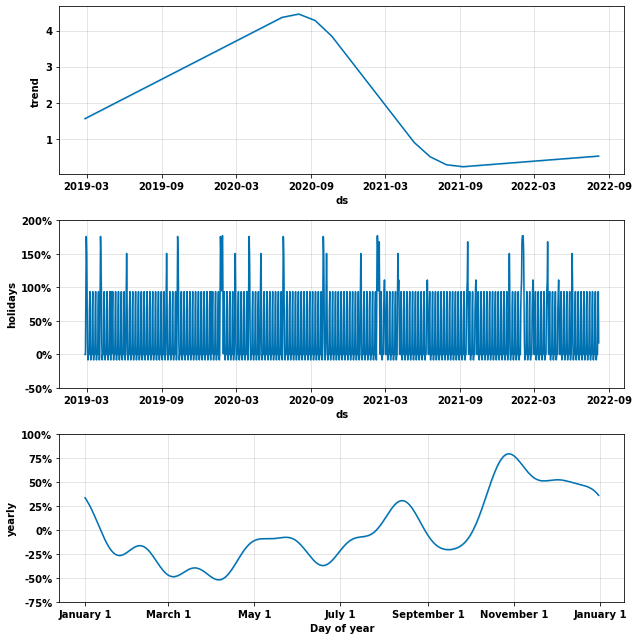

In [28]:
# https://github.com/facebook/prophet/issues/396
# You can place a ';' behind your statement in order to get the plot only once. I think this is due to the fact that the plot is already rendered in the function.

m.plot_components(fit_value);

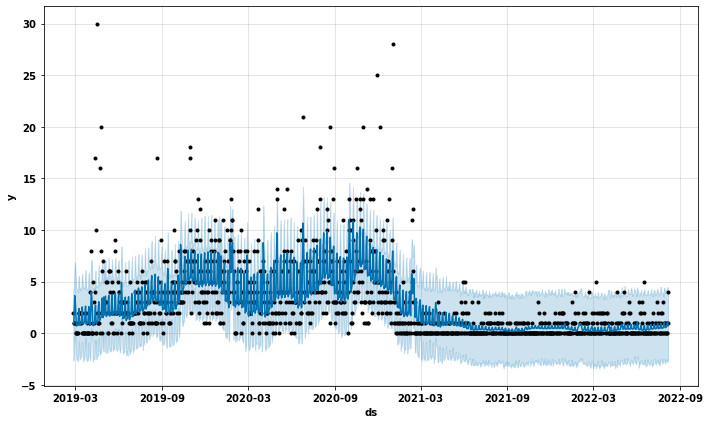

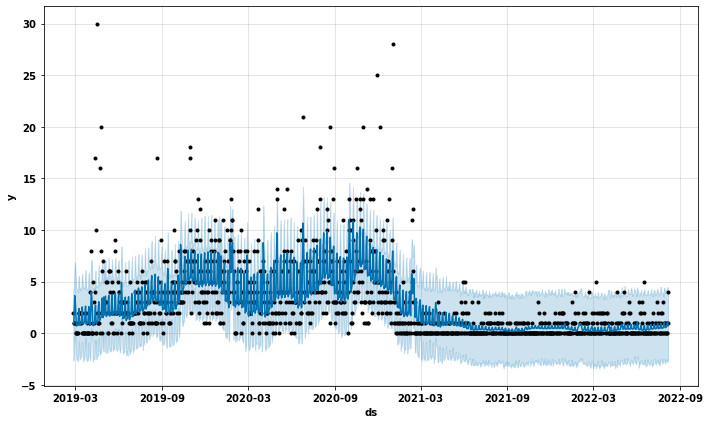

In [29]:
m.plot(fit_value)

In [30]:
fit_value

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,holiday,holiday_lower,holiday_upper,holidays,...,weekend,weekend_lower,weekend_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-02-25,1.561097,-2.654578,4.125497,1.561097,1.561097,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.407964,-0.407964,-0.407964,0.0,0.0,0.0,0.924226
1,2019-02-26,1.566899,-2.446491,4.435563,1.566899,1.566899,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.425831,-0.425831,-0.425831,0.0,0.0,0.0,0.899664
2,2019-02-27,1.572702,-0.781470,5.692140,1.572702,1.572702,0.935465,0.935465,0.935465,0.935465,...,0.000000,0.000000,0.000000,-0.441807,-0.441807,-0.441807,0.0,0.0,0.0,2.349079
3,2019-02-28,1.578504,0.306202,6.873797,1.578504,1.578504,1.757277,1.757277,1.757277,1.757277,...,0.000000,0.000000,0.000000,-0.455635,-0.455635,-0.455635,0.0,0.0,0.0,3.633152
4,2019-03-01,1.584307,-0.282011,6.736494,1.584307,1.584307,0.833091,0.833091,0.833091,1.515210,...,0.682119,0.682119,0.682119,-0.467118,-0.467118,-0.467118,0.0,0.0,0.0,3.244805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,2022-08-03,0.521645,-2.566727,4.004389,0.521645,0.521645,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.145054,0.145054,0.145054,0.0,0.0,0.0,0.597312
1256,2022-08-04,0.522531,-2.794752,3.910722,0.522531,0.522531,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.167793,0.167793,0.167793,0.0,0.0,0.0,0.610208
1257,2022-08-05,0.523417,-2.498749,4.373993,0.523417,0.523417,0.000000,0.000000,0.000000,0.682119,...,0.682119,0.682119,0.682119,0.190002,0.190002,0.190002,0.0,0.0,0.0,0.979900
1258,2022-08-06,0.524303,-2.544640,4.479155,0.524303,0.524303,0.000000,0.000000,0.000000,0.936357,...,0.936357,0.936357,0.936357,0.211271,0.211271,0.211271,0.0,0.0,0.0,1.126007


In [31]:
fit_value.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'holiday', 'holiday_lower', 'holiday_upper', 'holidays',
       'holidays_lower', 'holidays_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekend',
       'weekend_lower', 'weekend_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yhat'],
      dtype='object')